In [1]:
# inspired from: A deep understanding of deep learning


import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


import copy



import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# %matplotlib widget
%matplotlib notebook
%matplotlib inline


In [2]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

data = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

dataT = torch.tensor( dataNorm ).float()

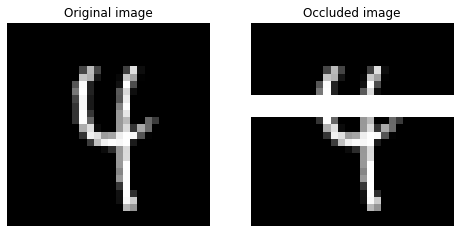

In [3]:
img = dataT[12345,:].view(28,28)


occluded = copy.deepcopy( img )
occluded[10:13,:] = 1

fig,ax = plt.subplots(1,2,figsize=(8,5))

ax[0].imshow(img,cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(occluded,cmap='gray')
ax[1].set_title('Occluded image')
ax[1].axis('off')

plt.show()

In [4]:
def createTheMNISTAE():

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,128)
      
      ### encoder layer
      self.enc = nn.Linear(128,50)

      ### latent layer
      self.lat = nn.Linear(50,128)

      ### decoder layer
      self.dec = nn.Linear(128,784)



    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.enc(x) )
      x = F.relu( self.lat(x) )
      y = torch.sigmoid( self.dec(x) )

      return y




  net = aenet()
  
  lossfun = nn.MSELoss()

  optimizer = torch.optim.Adam(net.parameters(),lr=.001)




  return net,lossfun,optimizer
  

In [5]:
def function2trainTheModel():

  numepochs = 5
  
  net,lossfun,optimizer = createTheMNISTAE()

  losses = []



  batchsize  = 32
  numBatches = int(dataT.shape[0]/batchsize)


  for epochi in range(numepochs):

    
    # get a permuted index vector
    randidx = np.random.permutation(dataT.shape[0]).astype(int)
    

    for batchi in range(numBatches):
      
      samps2use = range((batchi-1)*batchsize,batchi*batchsize)
      

      X = dataT[randidx[samps2use],:]

      yHat = net(X)
      loss = lossfun(yHat,X)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    
      losses.append( loss.item() )

  

  
  return losses,net



Final loss: 0.0126


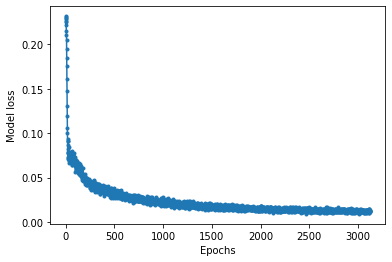

In [6]:
# train the model (16s)
losses,net = function2trainTheModel()
print(f'Final loss: {losses[-1]:.4f}')

plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

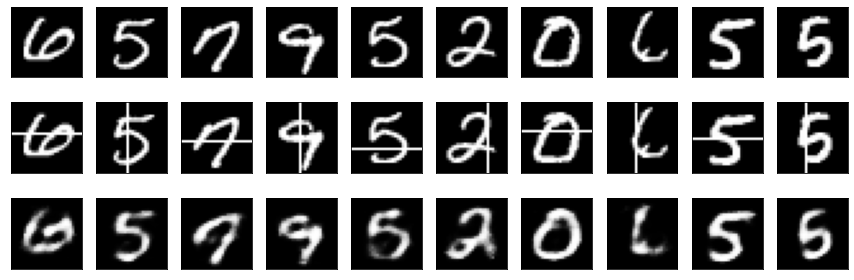

In [7]:
X = copy.deepcopy( dataT[:10,:] )

# add noise
for i in range(X.shape[0]):
  
  img = X[i,:].view(28,28)

  
  # occlude random rows or columns
  startloc = np.random.choice(range(10,21))
  
  if i%2==0: # even -> horizontal occlusion
    img[startloc:startloc+1,:] = 1
  
  else:      # odd -> vertical occlusion
    img[:,startloc:startloc+1] = 1



deOccluded = net(X)


fig,axs = plt.subplots(3,10,figsize=(15,5))

for i in range(10):
  axs[0,i].imshow(dataT[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[2,i].imshow(deOccluded[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  axs[2,i].set_xticks([]), axs[2,i].set_yticks([])
  
plt.show()

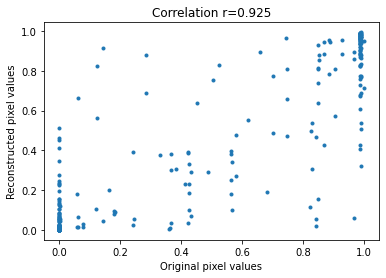

In [8]:
# We can quantify the performance of our "de-occluder" by correlating the sample with the original.

inOutCorr = np.corrcoef(dataT[9,:].detach(),deOccluded[9,:].detach())

plt.plot(dataT[9,:].detach(),deOccluded[9,:].detach(),'.')
plt.xlabel('Original pixel values')
plt.ylabel('Reconstructed pixel values')
plt.title(f'Correlation r={ inOutCorr[0,1] :.3f}')
plt.show()

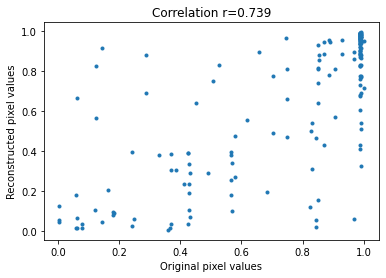

In [9]:
# try again without the zero-valued pixels

orig  = dataT[9,:].detach()
recon = deOccluded[9,:].detach()

# boolean vector that indicates pixels>0 (with some tolerance)
tol = 1e-4
nonzeropixels = (orig>tol) & (recon>tol)

# then re-compute the correlation
inOutCorr = np.corrcoef(orig[nonzeropixels],recon[nonzeropixels])

plt.plot(orig[nonzeropixels],recon[nonzeropixels],'.')
plt.xlabel('Original pixel values')
plt.ylabel('Reconstructed pixel values')
plt.title(f'Correlation r={ inOutCorr[0,1] :.3f}')
plt.show()

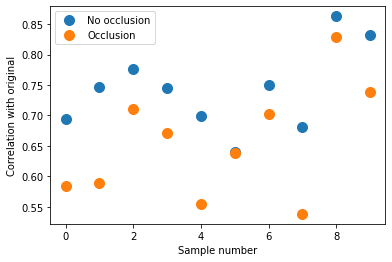

In [10]:
# get data with no occlusion
noOcclusion = net(dataT[:10,:])

# compare deOccluded-original to noOcclusion-original correlation
r = np.zeros((10,2))
for i in range(deOccluded.shape[0]):

  # pixel selection (note: tolerance defined in previous cell)
  nonzeropixels = (dataT[i,:]>tol) & (noOcclusion[i,:]>tol) & (deOccluded[i,:]>tol)

  # now compute the correlations
  r[i,0] = np.corrcoef(dataT[i,nonzeropixels].detach(),noOcclusion[i,nonzeropixels].detach())[0,1]
  r[i,1] = np.corrcoef(dataT[i,nonzeropixels].detach(),deOccluded[i,nonzeropixels].detach())[0,1]


# plot the correlation coefficients
plt.plot(r,'o',markersize=10)
plt.legend(['No occlusion','Occlusion'])
plt.xlabel('Sample number')
plt.ylabel('Correlation with original')
plt.show()